In Part 3 we return to Part 1 results. We stopped at filling NaNs. 

Let's load the filled datasets:

In [3]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']
train_from_part_1 = pd.read_csv('new_datasets/train_from_part_1.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test_from_part_1 = pd.read_csv('new_datasets/test_from_part_1.csv', index_col='ID_LAT_LON_YEAR_WEEK')

CPU times: total: 1.22 s
Wall time: 1.23 s


In [18]:
%%time

study_number = '00'

train = train_from_part_1.drop(['Location', 'week_no_category', 'Location+week_no'], axis=1)
test = test_from_part_1.drop(['Location', 'week_no_category', 'Location+week_no'], axis=1)

scores_df = pd.DataFrame({'Comment': [], 'Train Score': [], 'Cross-val Score': [], 'Test RMSE': []})

# Instantiate the estimator
# UNCOMMENT TO INSTALL LightGBM
#!pip install lightgbm
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1, n_estimators=10)

# Calculate scores
from functions.get_score import get_score

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train, test, 
                                                                     model, scores_df,
                                                                  comment="Part 3 Baseline")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)


CPU times: total: 15.6 s
Wall time: 1.82 s


In [19]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,52.255632,262.124712,NaN


## Principal Component Analysis

First, we'll reduce dimensionality of our dataset by transforming features to principal components.

We'll do so to achieve 2 goals:

-) Avoid possible overfitting

-) Reduce the runtime for testing and hyperparameters tuning

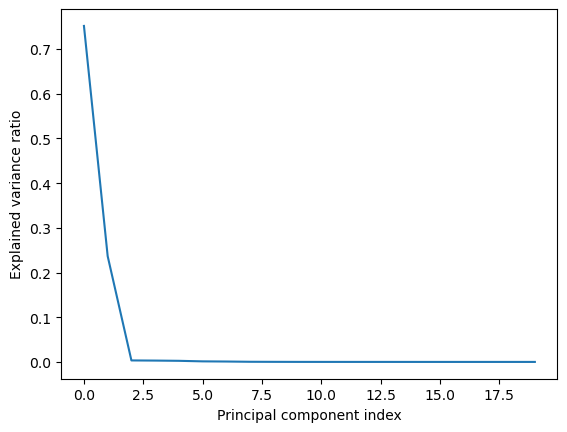

CPU times: total: 1.89 s
Wall time: 631 ms


In [6]:
%%time

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_train = train_from_part_1.drop(['Location', 'week_no_category', 'Location+week_no', 'emission'], axis=1)

pca = PCA(n_components = 20)

# Fit PCA
pca.fit(X_train)

# Plot the explained variance ratio
plt.plot(pca.explained_variance_ratio_)

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

## 00. Baseline. 2 PC

Interestingly, most of variance is explained just by 2 principal components. Let's tranform our features into 2 components:

In [8]:
%%time

study_number = '00'

pca = PCA(n_components = 2)

X_train = pca.fit_transform(X_train)

train = pd.concat([pd.DataFrame(X_train, index=train_from_part_1.index, columns=['PC1', 'PC2']),
                   train_from_part_1['emission']], axis=1)
                   
X_test = test_from_part_1.drop(['Location', 'week_no_category', 'Location+week_no'], axis=1)

X_test = pca.fit_transform(X_test)

test = pd.DataFrame(X_test, index=test_from_part_1.index, columns=['PC1', 'PC2'])

train.head()

CPU times: total: 281 ms
Wall time: 86.2 ms


,PC1,PC2,emission
ID_LAT_LON_YEAR_WEEK,,,
ID_-0.510_29.290_2019_00,-1907.319165,8021.508387,3.750994
ID_-0.510_29.290_2019_01,-13129.959182,7981.095381,4.025176
ID_-0.510_29.290_2019_02,-2682.194358,8016.326987,4.231381
ID_-0.510_29.290_2019_03,11704.858804,8065.499075,4.305286
ID_-0.510_29.290_2019_04,-8093.909118,7998.480290,4.347317


In [9]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PC1       79023 non-null  float64
 1   PC2       79023 non-null  float64
 2   emission  79023 non-null  float64
dtypes: float64(3)
memory usage: 2.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     24353 non-null  float64
 1   PC2     24353 non-null  float64
dtypes: float64(2)
memory usage: 570.8+ KB
None


Let's look at patterns in our transformed data:

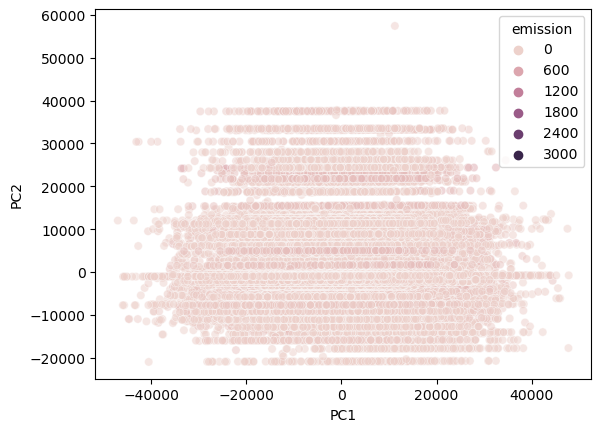

In [10]:
import seaborn as sns

sns.scatterplot(data=train, x='PC1', y='PC2', hue='emission', alpha=0.5)
plt.show()

Indeed, we see patterns. Let's calculates scores:

In [15]:
%%time

scores_df = pd.DataFrame({'Comment': [], 'Train Score': [], 'Cross-val Score': [], 'Test RMSE': []})

# Instantiate the estimator
# UNCOMMENT TO INSTALL LightGBM
#!pip install lightgbm
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1, n_estimators=10)

# Calculate scores
from functions.get_score import get_score

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train, test, 
                                                                     model, scores_df,
                                                                  comment="Part 3 Baseline")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 2.81 s
Wall time: 280 ms


In [16]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,131.734532,208.232961,NaN
